# Object Detection From Scratch - Part 1
by John Robinson 2022 [Follow @johnrobinsn on Twitter](https://twitter.com/johnrobinsn)

![jpeg](https://www.storminthecastle.com/img/01_classification_files/computervision1_256.jpeg)

[<img src="https://www.storminthecastle.com/img/github.svg">](https://github.com/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/01_classification.ipynb) [<img src="https://www.storminthecastle.com/img/colab.svg">](https://colab.research.google.com/github/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/01_classification.ipynb)

This is the start of a new article series on building an intuition for how single-pass object detectors such as YOLO and SSD work.  Object detection considers the problem of building a model that can take an image and detect multiple objects within that image; predicting not only the object classes but also the bounding boxes of those objects within the image.  Single-pass detectors such as YOLO and SSD have solved this problem end-to-end performing the object detection task in a single forward inference pass of the model.  If what I'm describing is not clear, here is a fun video of [YOLO in action](https://www.youtube.com/watch?v=MPU2HistivI).

In this series, I will incrementally build up a YOLO/SSD (Single Shot Detector) object model with just PyTorch and the current version of the FastAI 2 library.  Both SSD and YOLO allow for single pass inference and can run efficiently on fairly low-end hardware allowing for realtime object detection for video content etc.

In order to learn about object detection we'll need a dataset.  We'll be focused on using the [Pascal VOC dataset (2007)](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html).  In total this dataset includes almost 10k images, containing about 24k annotated objects covering 20 different object classes.  Each image is annotated with some number of object class labels and their cooresponding bounding boxes.

The notebooks in this series are designed to be easily used within Google Colab (free) or if you have your own GPU I'd recommend using conda to setup an environment with Python >3.9 and pip install fastai.

To easily open this notebook just click on the "Open in Colab" button above.

The FastAI (FAI) library makes it easy to download the Pascal VOC dataset and access the object annotations.  

In [1]:
from fastai.vision.all import *

/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Download the dataset using FAI's untar_data function and take a quick look at the files that have been downloaded.

In [2]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/home/jr/.fastai/data/pascal_2007/train.json'),Path('/home/jr/.fastai/data/pascal_2007/test.csv'),Path('/home/jr/.fastai/data/pascal_2007/train.csv'),Path('/home/jr/.fastai/data/pascal_2007/train'),Path('/home/jr/.fastai/data/pascal_2007/test.json'),Path('/home/jr/.fastai/data/pascal_2007/valid.json'),Path('/home/jr/.fastai/data/pascal_2007/segmentation'),Path('/home/jr/.fastai/data/pascal_2007/test')]

## Exploring the Dataset

FAI includes a get_annotations function that can parse COCO style bounding box annotations which the VOC dataset uses.  Here we'll just load the data associated with the train set (train.json).  The function will return a tuple of lists.  The first list will contain the image file names in the training set.  The second list will contain cooresponding bounding boxes and object class labels for those images.

In [3]:
imgs,lbl_bbox = get_annotations(path/'train.json')
len(imgs),len(lbl_bbox)

(2501, 2501)

The dataset provides over 2500 training labeled (classes and bounding boxes).  Here is a single example that demonstrates an image that has more than one object annotated.  Showing two bounding boxes in image-space coordinates along with their respective object class labels.

In [4]:
imgs[1],lbl_bbox[1]  # show a single example

('000017.jpg',
 ([[184, 61, 279, 199], [89, 77, 403, 336]], ['person', 'horse']))

The bounding boxes consist of four numbers, the first two numbers represent the xy coordinates of the upper left corner of the bounding box and the second two numbers represent the xy coordinates of the lower right corner of the bounding box.

## Visualize the Dataset
Using the matplotlib library let's visualize an example from the training set.

In [5]:
import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects

Let's grab a sample out of the training set to explore.

In [7]:
# grab our example
img_file,img_bbox = imgs[1],lbl_bbox[1]
img_file,img_bbox

('000017.jpg',
 ([[184, 61, 279, 199], [89, 77, 403, 336]], ['person', 'horse']))

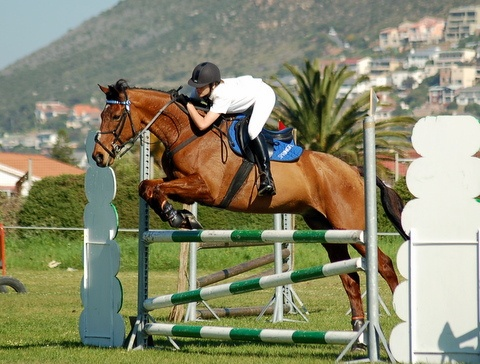

In [8]:
# load the image using PIL
img = Image.open(path/f'train/{img_file}')
img

In [12]:
h,w = img.shape
h,w # the height and width of the image; Note that height is typically specified first for numpy and PIL

(364, 480)

The images in the dataset come in different sizes and shapes (but all 3 channel RGB images).  In order to be able to use a GPU to accelerate training, we will want to work with a batch of images all in one go.  This means that all of our images will need to be of the same size so that we can stack a batch into a single tensor.  A fairly typical size to work with is 224x224 pixels.  One important consideration is that since our bounding boxes are defined in image space coordinates, we really don't want to crop the images since we might cut off our bounding boxes, therefore we opt to squish the images instead.

In [13]:
SIZE=224

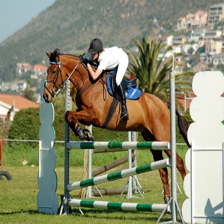

In [14]:
# resample/rescale the example image by squishing
img_scaled = img.resize((SIZE,SIZE))
img_scaled

Given the task of object detection our independent variable are the images and the dependent variables are the object classes and the object bounding boxes.  Given an image, we will want our model to predict a class label for each object in the image along with a bounding box for each object.  One wrinkle however is that our bounding box (dependent variable) is defined in the coordinate space of our image (independent variable).  So if we scale the input image we must also be careful to scale the bounding boxes along with it.  Since the image has been squished to be of size 224x224 pixels we need to squish (scale) the dimensions our bounding boxes for that sample by the same amount.  Here I show the steps required to squish the dimensions of the bounding boxes for our sample.

In [17]:
# calculate how how much we've scaled each dimension of the image
yscale,xscale = h/SIZE,w/SIZE
yscale,xscale

(1.625, 2.142857142857143)

In [18]:
# apply the same scale factor to each coordinate of the bounding box
img_bbox_scaled = [[x1//xscale,y1//yscale,x2//xscale,y2//yscale] for x1,y1,x2,y2 in img_bbox[0]]
img_bbox_scaled

[[85.0, 37.0, 130.0, 122.0], [41.0, 47.0, 188.0, 206.0]]

In [19]:
# reconstruct the labled set of bounding boxes with the scaled bounding boxes for our example
img_bbox_scaled = (img_bbox_scaled,img_bbox[1])
img_bbox_scaled

([[85.0, 37.0, 130.0, 122.0], [41.0, 47.0, 188.0, 206.0]], ['person', 'horse'])

Here is a small utility function for displaying an image in such a way that we can layer on some additional annotations.

In [20]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

<AxesSubplot: >

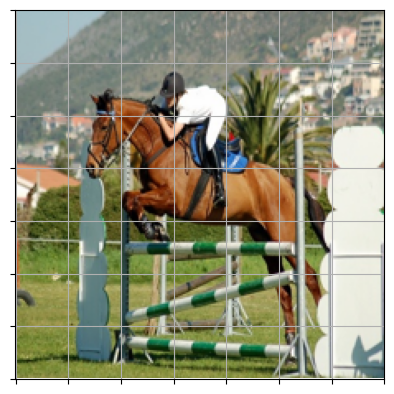

In [21]:
show_img(img_scaled)

We will want to be able to overlay the class labels on top of our image in the appropriate locations along with the bounding boxes for each object.  Here are a couple of utility functions that allow us to draw text on top of an image and allow us to draw a rectangle on top of an image.  

In [23]:
# draw an outline around the shape; used to add contrast to the text so we can read it easily
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

# draw text in the specified location along with an outline so that there is some contrast between the text and the image
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [24]:
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

In [28]:
# generate a list of different colors for rendering our bounding boxes
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [29]:
# draw an image along with it's associated bounding boxes and class labels
def show_item(im, lbl_bbox, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax = show_img(im, ax=ax)
    for i,(b,c) in enumerate(zip(lbl_bbox[0], lbl_bbox[1])):
        b = (*b[:2],b[2]-b[0]+1,b[3]-b[1]+1)
        draw_rect(ax, b, color=colr_list[i%num_colr])
        draw_text(ax, b[:2], c, color=colr_list[i%num_colr])

Let's draw our scaled image along with it's scaled bounding boxes and class labels.

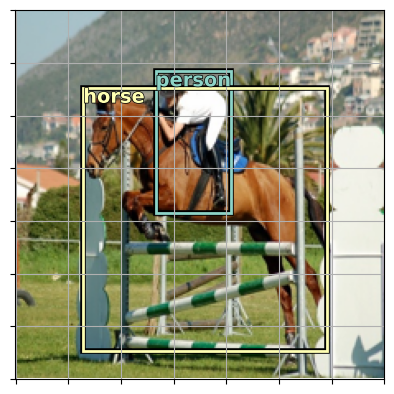

In [31]:
show_item(img_scaled,img_bbox_scaled)

By now you should have a pretty good understanding of what the dataset looks like.  Our goal for this series of articles will be to use this dataset to develop and train an object detection model that can take an image as input and will output a list of class labels for each object within the image along with their respective bounding boxes.  But we will do this incrementally in order to build up an intuition of how the system will work.

## Decomposing the problem
Let's start with a easier problem and work our way up from there.  Let's make a much simpler model, one that takes an image as input and predicts just a single object class for the image.  let's do this for the largest object present in each image.  We can use our dataset and the bounding box information that we have to identify the largest object in each image and use that as a derived dataset to get us started.

Here we have written a function that given a labeled bounding box sample will return the largest single bounding box along with it's class label.

In [32]:
# utility function that takes a bounding box in the form of x1,y1,x2,y2 and returns it's area (w*h)
def area(b): return (b[2]-b[0])*(b[3]-b[1])

# zip the bounding boxes together with the object class; 
# sort it descending order by the size of the bounding; 
# return the first one (largest one)
def get_largest(boxes):
    return sorted(L(zip(*boxes)),key=lambda b: -area(b[0]))[0]

Review our sample out of the dataset.

In [33]:
# our labled bounding box sample
img_bbox_scaled

([[85.0, 37.0, 130.0, 122.0], [41.0, 47.0, 188.0, 206.0]], ['person', 'horse'])

Use the get_largest function to get the largest object for a given sample.

In [34]:
# get the largest object from our sample
get_largest(img_bbox_scaled)

([41.0, 47.0, 188.0, 206.0], 'horse')

Now that we have a way to get the largest object for a sample we can just use a list comprehension to process all of the training metadata and produce a new training set that just contains the largest objects for each image.

In [35]:
lrg_bbox = [get_largest(boxes) for boxes in lbl_bbox]

Create a dictionary that we can use to look up we can look up our dependent variables (largest object and bounding box for each image) given the independent variable(img file name)

In [36]:
img2lrgbbox = dict(zip(imgs,lrg_bbox))

In [37]:
# look at a sample from our dictionary
k = L(img2lrgbbox)[1]; k,img2lrgbbox[k]

('000017.jpg', ([89, 77, 403, 336], 'horse'))

## Training a Classification Model
Let's setup and train a model that will classify the largest object within a given image.  Fast AI makes this pretty quick and easy using the DataBlock API.  For now we won't use the bounding box information but just use the class label from the largest object dictionary that we created.

### Setting up the Dataloaders

Define a getter for the DataBlock API.  Given a training image file name will return the full path to the image file and the class label of the largest object in that image.

In [38]:
# returns [full path to image file, largest object class name]
getters = [lambda o: path/'train'/o, lambda o: img2lrgbbox[o][1]]

Try out the Datablock getter providing an image file name from our dataset (k).

In [40]:
k,getters[0](k),getters[1](k)

('000017.jpg',
 Path('/home/jr/.fastai/data/pascal_2007/train/000017.jpg'),
 'horse')

A few image transforms. 
item_tfms will be used to make all of the dataset images the same size.
batch_tfms will be used to procedurally create more training data to improve our model performance.

In [41]:
item_tfms = [Resize(224, method='squish'),]
batch_tfms = [Rotate(10), Flip(), Dihedral()]  # Some basic image augmentions so that that our model get's more input image diversity during training

In [42]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [43]:
dls = dblock.dataloaders(imgs, bs = 128)

Fast AI will look at the dataset and collect all of the classes that our dataset contains which yields 20 class as follows:

In [44]:
dls.vocab,len(dls.vocab)

(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
 20)

Now that our data has been setup, Fast AI can show us a sample training batch that will be fed into the model for training.  Showing the images and the ground truth labels for the largest object in the image.

_Note: Image augmentations specified above will be randomly applied._

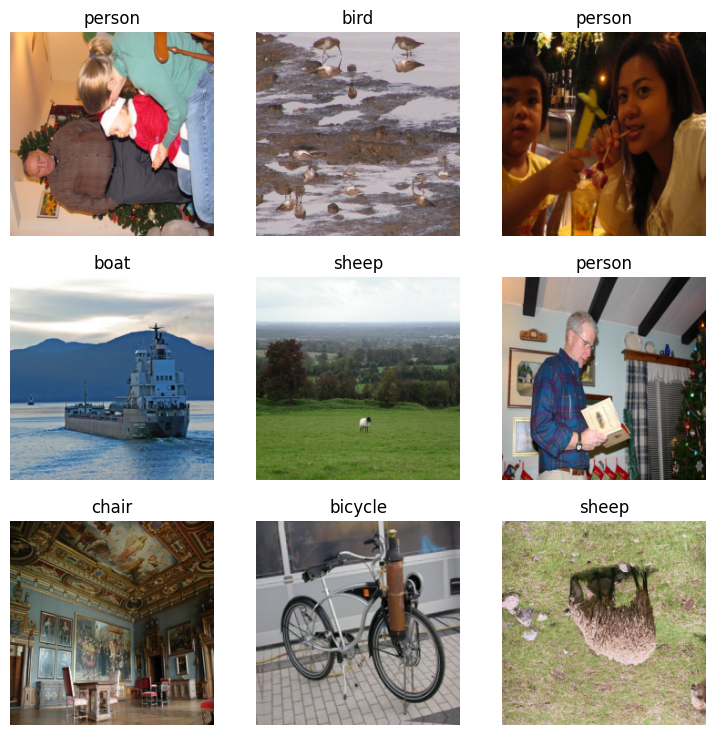

In [36]:
dls.show_batch()


We can now use the vision_learner API and specify our dataset, the model architecture that we'd like to use, and any training metrics that we'd like to see while training.

Here we'll use resnet34 model which provides a pretty good mix of capacity and performance for our experiment.   Here FAI uses transfer learning by default where the pretrained weights for the resnet34 model will be used.

_Note: These pretrained weights were trained against the imagenet dataset and will enable our model to learn much faster._

In [45]:
learn = vision_learner(dls,resnet34,metrics=accuracy)

/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fast AI auto selects a suitable loss function for a classification model given that we specified the CategoryBlock via the DataBlock API.  We can examine the selected loss function here.

In [46]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Let's find a reasonble learning rate.

SuggestedLRs(valley=0.0008317637839354575)

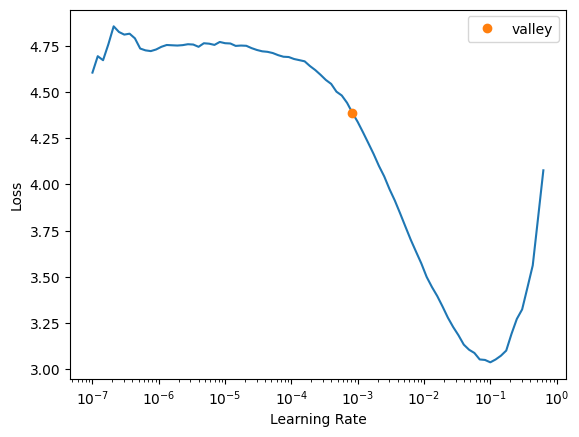

In [47]:
lrs = learn.lr_find()
lrs

### Train Our Model
We'll fit the model to our training data using the selected loss function.  Here we're using fine_tune since we are using the resnet34 pretrained weights.

In [48]:
learn.fine_tune(10,base_lr=lrs.valley)

epoch,train_loss,valid_loss,accuracy,time
0,4.157558,1.687271,0.538000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,2.541830,1.374761,0.622000,00:06
1,2.298766,1.057605,0.692000,00:06
2,1.984269,0.888334,0.746000,00:06
3,1.709419,0.845897,0.780000,00:06
4,1.484500,0.803179,0.774000,00:06
5,1.295198,0.795235,0.772000,00:06
6,1.144498,0.789521,0.786000,00:06
7,1.041366,0.787113,0.782000,00:06
8,0.958484,0.785957,0.780000,00:06
9,0.887360,0.789864,0.780000,00:06


We're able to get to about 80% accuracy pretty quickly which isn't too bad given that we're trying to predict a single class label to represent the image. Most of the images have multiple objects and the largest objects aren't centered which adds some amount of confusion.

Let's look at a few predictions showing both the ground-truth label and the label predicted by our trained model.

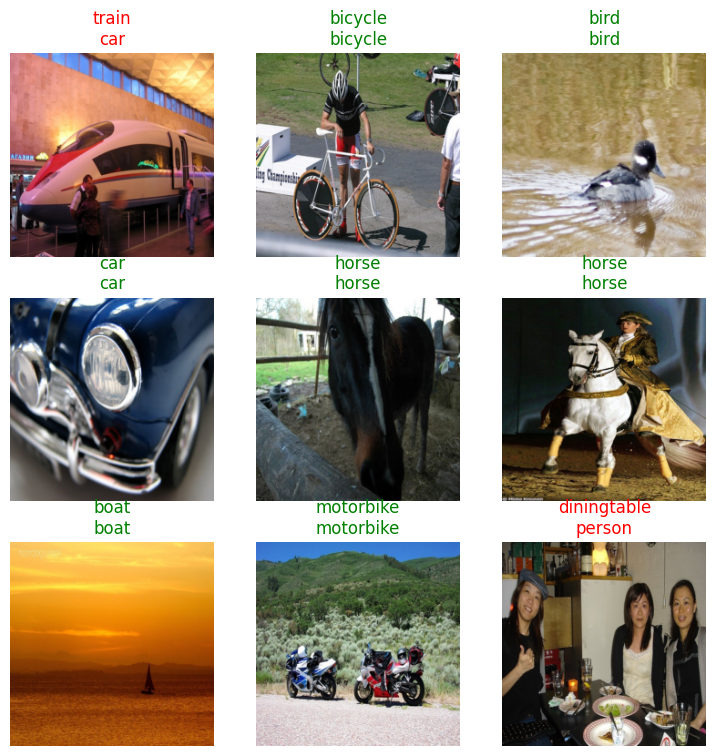

In [49]:
learn.show_results()

## Summary
In this article, we started explored the problem of object detection.  We selected and explored a dataset that we can use for experimentation and we trained a model to classify the largest object within an image.  

In my next article, I'll start to show how we can climb one more rung up the ladder and walk you through how we can design a model to handle bounding boxes.  Building a regression model that can predict the bounding box for the largest object in the image without the class label.  

This article series leverages the current version of the [Fast AI 2 library](https://github.com/fastai/fastai), but the overall ideas and arc are based on [Jeremy Howard's](https://twitter.com/jeremyphoward) 2018 course, "Cutting Edge Deep Learning for Coders 2" where he covers Object Detection.  He starts discussing Object Detection starting with this video on YouTube [Single object detection](https://www.youtube.com/watch?v=Z0ssNAbe81M&t=6s).  This course used an older version of the Fast AI library which has significantly evolved, but Jeremy's experience and teaching-style makes this course and [his latest course](https://www.fast.ai/posts/part2-2022-preview.html) highly recommended.